In [1]:
import time, os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from get_dataset import load_dataset
from get_dataset import get_trainset
from get_dataset import scaler_user
from embedding import embedding_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
loss = 'categorical_crossentropy'
lr = 0.00001
batch_size = 64
epochs = 300

In [3]:
created_time = int(time.time())
os.mkdir(f"model/{created_time}_{loss}_{lr}_{batch_size}")

user, item, label = load_dataset()

rent = user[:,5].astype(np.float32)
body = user[:,6].astype(np.float32)
user = user[:,0:5].astype(np.float32)
label = to_categorical(label[:,1],3)

id = item[:,0].astype(np.float32)
cat = item[:,1].astype(np.float32)
item = item[:,2].astype(np.float32)

In [4]:
user[:,0] = (user[:,0]-34)/117
user[:,1] = (user[:,1]-137.3)/163
user[:,2] = (user[:,2]-165.8)/29
user[:,3] = (user[:,3]-35)/14
user[:,4] = (user[:,4]-3.2)/9

item = (item-12)/60

In [5]:
print(item)

[ 0.03333334  0.         -0.13333334 ... -0.06666667  0.06666667
  0.06666667]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rent_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 cat_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 id_input (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

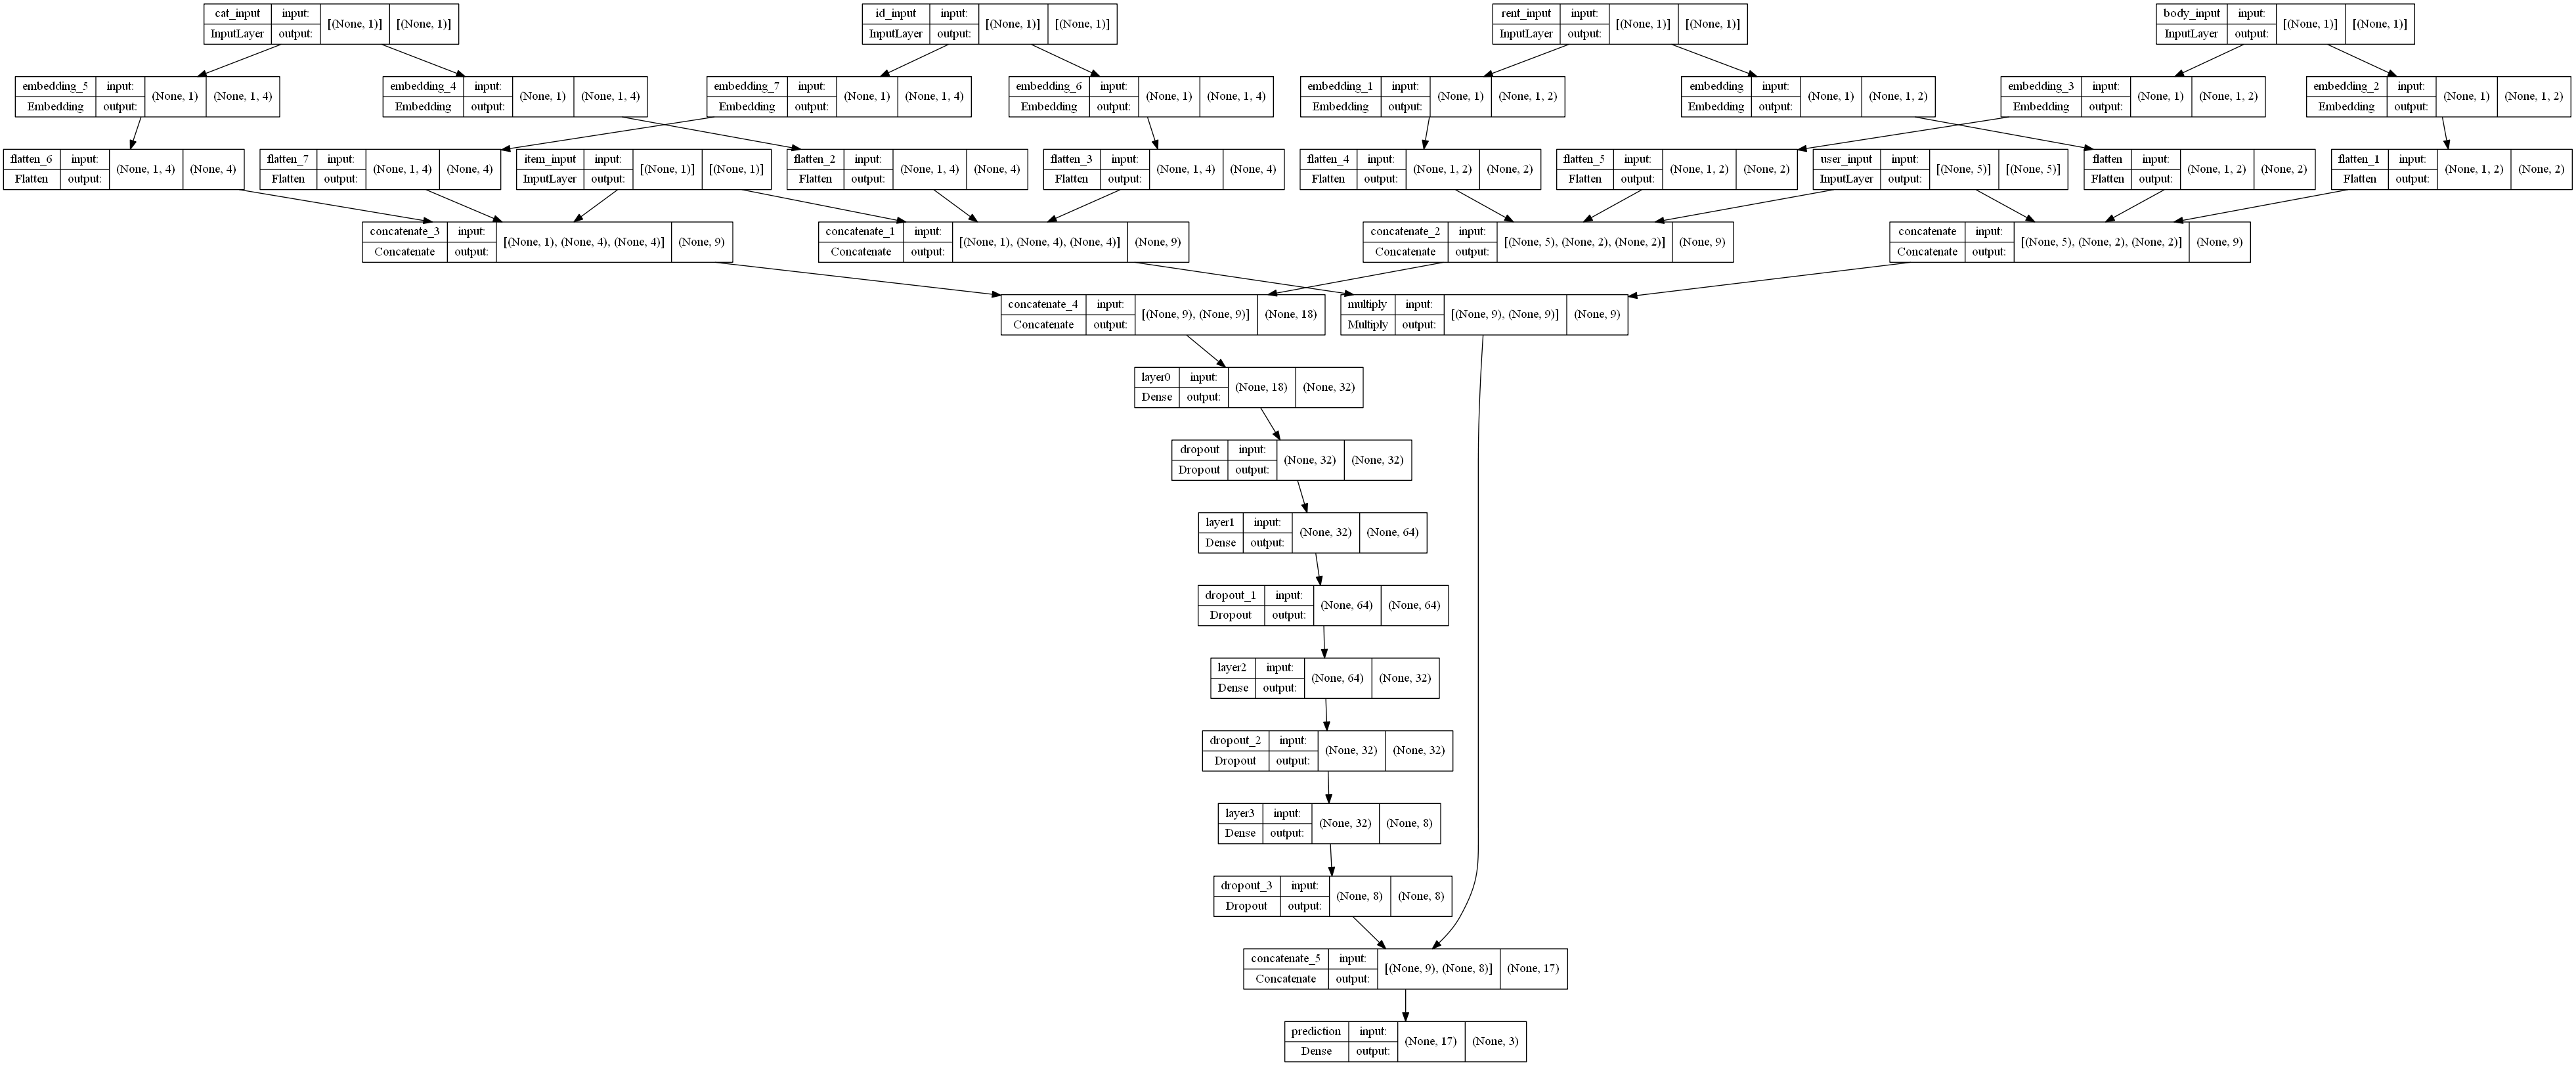

In [6]:
model = embedding_model()
model.summary()

plot_model(model, show_shapes=True)

In [1]:
user_train, user_val, rent_train, rent_val, body_train, body_val, item_train, item_val, cat_train, cat_val, id_train, id_val, label_train, label_val = train_test_split(user, rent, body, item, cat, id, label, test_size=0.1, random_state=2022)

print(np.shape(user_train))
print(np.shape(rent_train))
print(np.shape(body_train))
print(np.shape(item_train))
print(np.shape(cat_train))
print(np.shape(id_train))
print(np.shape(label_train))

NameError: name 'train_test_split' is not defined

In [8]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.000001, patience=7, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)

In [9]:
model.compile(optimizer=Adam(learning_rate = lr), loss=loss, metrics=[tf.keras.metrics.AUC(),'accuracy'])
history = model.fit([user_train, rent_train, body_train, id_train, cat_train, item_train], label_train, epochs=epochs, batch_size=batch_size, validation_data=([user_val, rent_val, body_val, id_val, cat_val, item_val], label_val),callbacks=[cb])

Epoch 1/300
2708/2708 [==============================] - 18s 6ms/step - loss: 1.0104 - auc: 0.7981 - accuracy: 0.7056 - val_loss: 0.8842 - val_auc: 0.8059 - val_accuracy: 0.7399
Epoch 2/300
2708/2708 [==============================] - 17s 6ms/step - loss: 0.8339 - auc: 0.8043 - accuracy: 0.7375 - val_loss: 0.7715 - val_auc: 0.8074 - val_accuracy: 0.7399
Epoch 3/300
2708/2708 [==============================] - 13s 5ms/step - loss: 0.8054 - auc: 0.8040 - accuracy: 0.7376 - val_loss: 0.7624 - val_auc: 0.8099 - val_accuracy: 0.7399
Epoch 4/300
2708/2708 [==============================] - 14s 5ms/step - loss: 0.7950 - auc: 0.8066 - accuracy: 0.7375 - val_loss: 0.7580 - val_auc: 0.8129 - val_accuracy: 0.7399
Epoch 5/300
2708/2708 [==============================] - 14s 5ms/step - loss: 0.7884 - auc: 0.8076 - accuracy: 0.7376 - val_loss: 0.7552 - val_auc: 0.8163 - val_accuracy: 0.7399
Epoch 6/300
2708/2708 [==============================] - 10s 4ms/step - loss: 0.7841 - auc: 0.8082 - accuracy:

In [14]:
model.save(f'model/{created_time}_{loss}_{lr}_{batch_size}/model.h5')

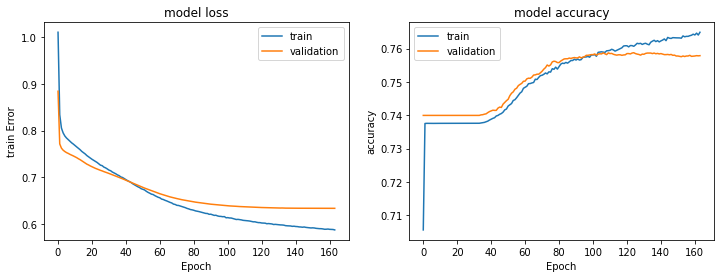

In [15]:
from tensorflow.keras.models import load_model
model_list= os.listdir('./models')
model = load_model(f'models/{model_list[-1]}/model.h5')


plt.figure(figsize=(12,4), facecolor='white')
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel("Epoch")
plt.ylabel("train Error")
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/train_error.png")
plt.show()

In [16]:
print(label_val)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


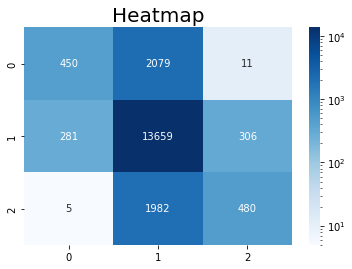

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


#Predict
y_prediction = model.predict([user_val, rent_val, body_val, id_val, cat_val, item_val])


# #Create confusion matrix and normalizes it over predicted (columns)
label = np.argmax(label_val, axis = 1)

y= np.argmax(y_prediction, axis = 1)

result = confusion_matrix(label, y)

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
plt.figure(facecolor='white')
ax = sns.heatmap(result, annot=True,fmt='d',cmap='Blues',norm=LogNorm())
plt.title('Heatmap', fontsize=20)
plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/heatmap.png")
plt.show()